In [41]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [42]:
def load_and_resize_images(image_dir, mask_dir, target_size=(256, 256)):
    images = []
    masks = []

    image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
    for image_file in image_files:
        image_path = os.path.join(image_dir, image_file)
        mask_path = os.path.join(mask_dir, image_file)  # Assurez-vous que les masques ont le même nom de fichier

        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Les masques sont souvent en niveaux de gris

        image = cv2.resize(image, target_size)
        mask = cv2.resize(mask, target_size)

        images.append(image)
        masks.append(mask)

    return np.array(images), np.array(masks)


In [43]:
image_dir = '/home/riccardo/Visual_Studio_Code/Grain-segmentation_prjt/dataset/martensite microstructure/converted_to_png'
mask_dir = '/home/riccardo/Visual_Studio_Code/Grain-segmentation_prjt/dataset/martensite microstructure/martensite_microstructure_preprocessed'

In [44]:
X, Y = load_and_resize_images(image_dir, mask_dir)

In [45]:
X_scaled = X / 255.0
Y_scaled = Y / 255.0  # Assurez-vous que vos masques sont également sur une échelle de 0 à 255 avant de faire ça.

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=20,horizontal_flip=True,featurewise_center=True,width_shift_range=0.2,
    height_shift_range=0.2,validation_split=0.2)

datagen.fit(X_scaled)

In [46]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

def create_vgg(input_size):
    # Chargez le modèle VGG16 pré-entraîné sans les couches supérieures (top)
    vgg = VGG16(include_top=False, weights='imagenet', input_shape=input_size)

    # Bloquez les couches VGG pour ne pas les entraîner
    for layer in vgg.layers:
        layer.trainable = False

    # Extraction des couches intermédiaires pour les connexions de saut
    block1_conv2 = vgg.get_layer('block1_conv2').output
    block2_conv2 = vgg.get_layer('block2_conv2').output
    block3_conv3 = vgg.get_layer('block3_conv3').output
    block4_conv3 = vgg.get_layer('block4_conv3').output
    block5_conv3 = vgg.get_layer('block5_conv3').output

    # Partie d'expansion (U-Net)
    # Démarrez avec la sortie du dernier bloc VGG
    x = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(block5_conv3)
    x = concatenate([x, block4_conv3])
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)

    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x)
    x = concatenate([x, block3_conv3])
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = concatenate([x, block2_conv2])
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
    x = concatenate([x, block1_conv2])
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    # Couche de sortie
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)

    model = Model(inputs=vgg.input, outputs=outputs)
    return model

# Créer le modèle U-Net basé sur VGG16
input_size = (256, 256, 3)  # Ajustez à la taille de vos images
model = create_vgg(input_size)

# Compiler le modèle
model.compile(optimizer=Adam(lr=1e-4), loss=MeanSquaredError(), metrics=['mae'])

# Afficher le résumé du modèle
model.summary()

# Entraîner le modèle avec vos données
# Assurez-vous que vos données sont préparées correctement
# history = model.fit(X_train, Y_train, ...)


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

model = unet_model()

history = model.fit(datagen.flow(X_scaled, Y_scaled, subset='training',batch_size=2), validation_data=datagen.flow(X_scaled, Y_scaled,
         batch_size=2, subset='validation'),epochs=50)

In [51]:
history = model.fit(X_scaled, Y_scaled, epochs=300, batch_size=2, validation_split=0.1)

Epoch 1/300
28/28 [==============================] - 3s 123ms/step - loss: 0.0257 - mae: 0.1230 - val_loss: 0.0504 - val_mae: 0.1732
Epoch 2/300
28/28 [==============================] - 3s 121ms/step - loss: 0.0252 - mae: 0.1221 - val_loss: 0.0507 - val_mae: 0.1752
Epoch 3/300
28/28 [==============================] - 3s 122ms/step - loss: 0.0244 - mae: 0.1197 - val_loss: 0.0503 - val_mae: 0.1747
Epoch 4/300
28/28 [==============================] - 3s 120ms/step - loss: 0.0247 - mae: 0.1207 - val_loss: 0.0515 - val_mae: 0.1735
Epoch 5/300
28/28 [==============================] - 3s 122ms/step - loss: 0.0242 - mae: 0.1184 - val_loss: 0.0584 - val_mae: 0.1918
Epoch 6/300
28/28 [==============================] - 3s 121ms/step - loss: 0.0251 - mae: 0.1213 - val_loss: 0.0563 - val_mae: 0.1837
Epoch 7/300
28/28 [==============================] - 3s 123ms/step - loss: 0.0238 - mae: 0.1180 - val_loss: 0.0558 - val_mae: 0.1852
Epoch 8/300
28/28 [==============================] - 3s 121ms/step - 

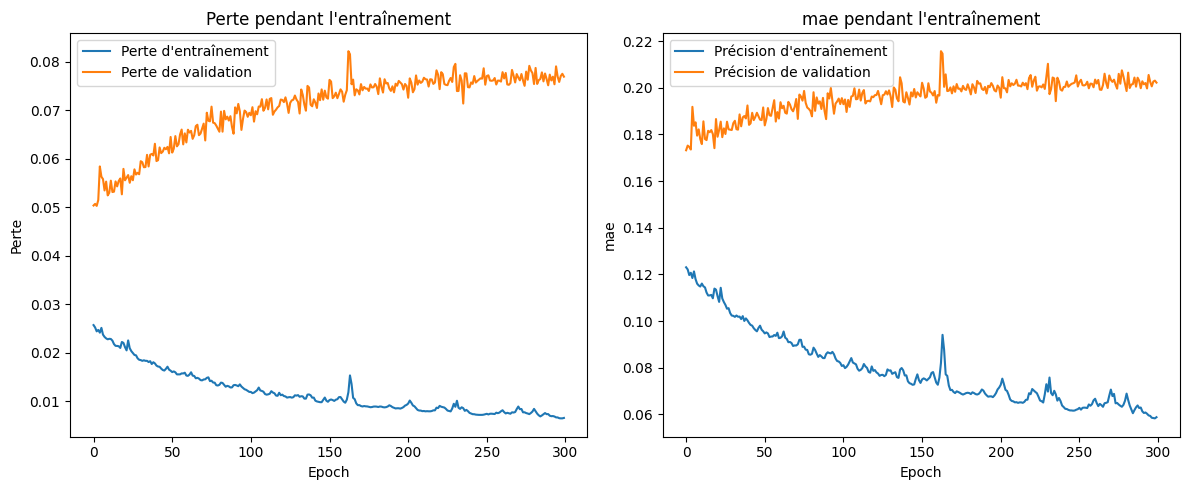

In [52]:
# Afficher les courbes d'entraînement
plt.figure(figsize=(12, 5))

# Affichage de la perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perte d\'entraînement')
plt.plot(history.history['val_loss'], label='Perte de validation')
plt.title('Perte pendant l\'entraînement')
plt.xlabel('Epoch')
plt.ylabel('Perte')
plt.legend()

# Affichage de la précision
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Précision d\'entraînement')
plt.plot(history.history['val_mae'], label='Précision de validation')
plt.title('mae pendant l\'entraînement')
plt.xlabel('Epoch')
plt.ylabel('mae')
plt.legend()

plt.tight_layout()
plt.show()

In [53]:
prediction = model.predict(np.expand_dims(X_scaled[1], axis=0))

In [ ]:
# Supposons que X_scaled est votre dataset d'images et Y_scaled sont vos masques/labels
# Nous afficherons l'image originale, la prédiction et le vrai masque côte à côte

num_images =61  # Nombre d'images à afficher
fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 3))  # 3 colonnes pour image, prédiction, masque

for i in range(num_images):
    prediction = model.predict(np.expand_dims(X_scaled[i], axis=0))[0]  # Prédire pour une image
    prediction = prediction.reshape(256, 256)  # Ajuster la forme si nécessaire

    # Afficher l'image originale
    axes[i, 0].imshow(X_scaled[i])
    axes[i, 0].set_title(f'Image Originale {i}')
    axes[i, 0].axis('off')

    # Afficher la prédiction
    axes[i, 1].imshow(prediction, cmap='gray')
    axes[i, 1].set_title(f'Prédiction {i}')
    axes[i, 1].axis('off')

    # Afficher le masque vrai
    axes[i, 2].imshow(Y_scaled[i].reshape(256, 256), cmap='gray')  # Ajuster la forme si nécessaire
    axes[i, 2].set_title(f'Masque Réel {i}')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()


model.save('seg_dataset2.h5')

TEST DU MODEL 

In [125]:
from tensorflow.keras.models import load_model
model = load_model('/home/riccardo/Visual_Studio_Code/Grain-segmentation_prjt/Models/seg_dataset2.h5')

In [126]:
target_size = (256, 256) 

image_path1 = '/home/riccardo/Visual_Studio_Code/Grain-segmentation_prjt/Pct_training/test1.png'
image_path2 = '/home/riccardo/Visual_Studio_Code/Grain-segmentation_prjt/Pct_training/test2.png'
image_path3 = '/home/riccardo/Visual_Studio_Code/Grain-segmentation_prjt/Pct_training/test3.png'
image_path4 = '/home/riccardo/Visual_Studio_Code/Grain-segmentation_prjt/Pct_training/test4.png'
image_path5 = '/home/riccardo/Visual_Studio_Code/Grain-segmentation_prjt/Pct_training/test5.png'


image1 = cv2.imread(image_path1, cv2.IMREAD_COLOR)
image2 = cv2.imread(image_path2, cv2.IMREAD_COLOR)
image3 = cv2.imread(image_path3, cv2.IMREAD_COLOR)
image4 = cv2.imread(image_path4, cv2.IMREAD_COLOR)
image5 = cv2.imread(image_path5, cv2.IMREAD_COLOR)


image1 = np.array(cv2.resize(image1, target_size))/255
image2 = np.array(cv2.resize(image2, target_size))/255
image3 = np.array(cv2.resize(image3, target_size))/255
image4 = np.array(cv2.resize(image4, target_size))/255
image5 = np.array(cv2.resize(image5, target_size))/255


In [127]:
prediction = model.predict(np.expand_dims(image3, axis=0))

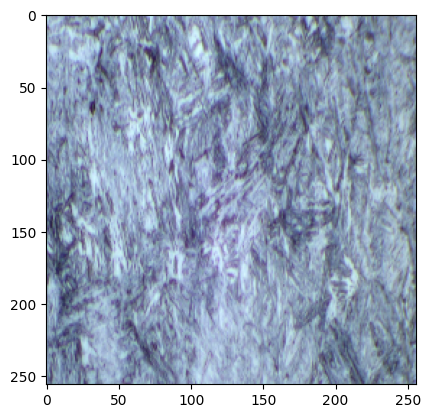

In [131]:
image = image5
plt.imshow(image)

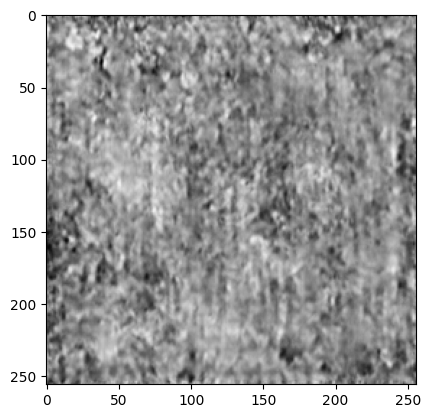

In [132]:
prediction = model.predict(np.expand_dims(image, axis=0))
plt.imshow(prediction.reshape(256, 256,1),cmap='gray')

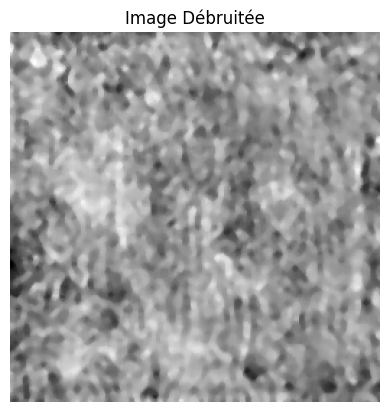

In [133]:
# Supprimer la dimension de lot et la dimension de canal pour obtenir une image 2D
prediction_2d = prediction.squeeze()

# Appliquer le filtre médian
prediction_denoised = cv2.medianBlur(prediction_2d, 5)

# Afficher l'image débruitée
plt.imshow(prediction_denoised, cmap='gray')
plt.title('Image Débruitée')
plt.axis('off')
plt.show()
